<a href="https://colab.research.google.com/github/bmuv/A-random-Repo/blob/master/Assignment3_Spambase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz
!tar xf spark-3.2.3-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.3-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [ ]:
from pyspark.sql.functions import col, udf, corr, expr
import pyspark.sql.functions as F

from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector, SparseVector
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, RandomForestClassifier, LogisticRegression, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.sql.types import FloatType, DoubleType

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
column_names = [
    "word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d", "word_freq_our",
    "word_freq_over", "word_freq_remove", "word_freq_internet", "word_freq_order", "word_freq_mail",
    "word_freq_receive", "word_freq_will", "word_freq_people", "word_freq_report", "word_freq_addresses",
    "word_freq_free", "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit",
    "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money", "word_freq_hp",
    "word_freq_hpl", "word_freq_george", "word_freq_650", "word_freq_lab", "word_freq_labs",
    "word_freq_telnet", "word_freq_857", "word_freq_data", "word_freq_415", "word_freq_85",
    "word_freq_technology", "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct",
    "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project", "word_freq_re",
    "word_freq_edu", "word_freq_table", "word_freq_conference", "char_freq_;", "char_freq_(",
    "char_freq_[", "char_freq_!", "char_freq_$", "char_freq_#", "capital_run_length_average",
    "capital_run_length_longest", "capital_run_length_total", "is_spam"
]

data_path = "/content/drive/My Drive/Colab Notebooks/spambase.data"
df = spark.read.csv(data_path, inferSchema=True).toDF(*column_names)

df.show(5)


+--------------+-----------------+-------------+------------+-------------+--------------+----------------+------------------+---------------+--------------+-----------------+--------------+----------------+----------------+-------------------+--------------+------------------+---------------+-------------+----------------+--------------+--------------+-------------+---------------+------------+-------------+----------------+-------------+-------------+--------------+----------------+-------------+--------------+-------------+------------+--------------------+--------------+---------------+------------+----------------+------------+-----------------+------------------+-----------------+------------+-------------+---------------+--------------------+-----------+-----------+-----------+-----------+-----------+-----------+--------------------------+--------------------------+------------------------+-------+
|word_freq_make|word_freq_address|word_freq_all|word_freq_3d|word_freq_our|word_f

# CORRELATION ANALYSIS

<Axes: >

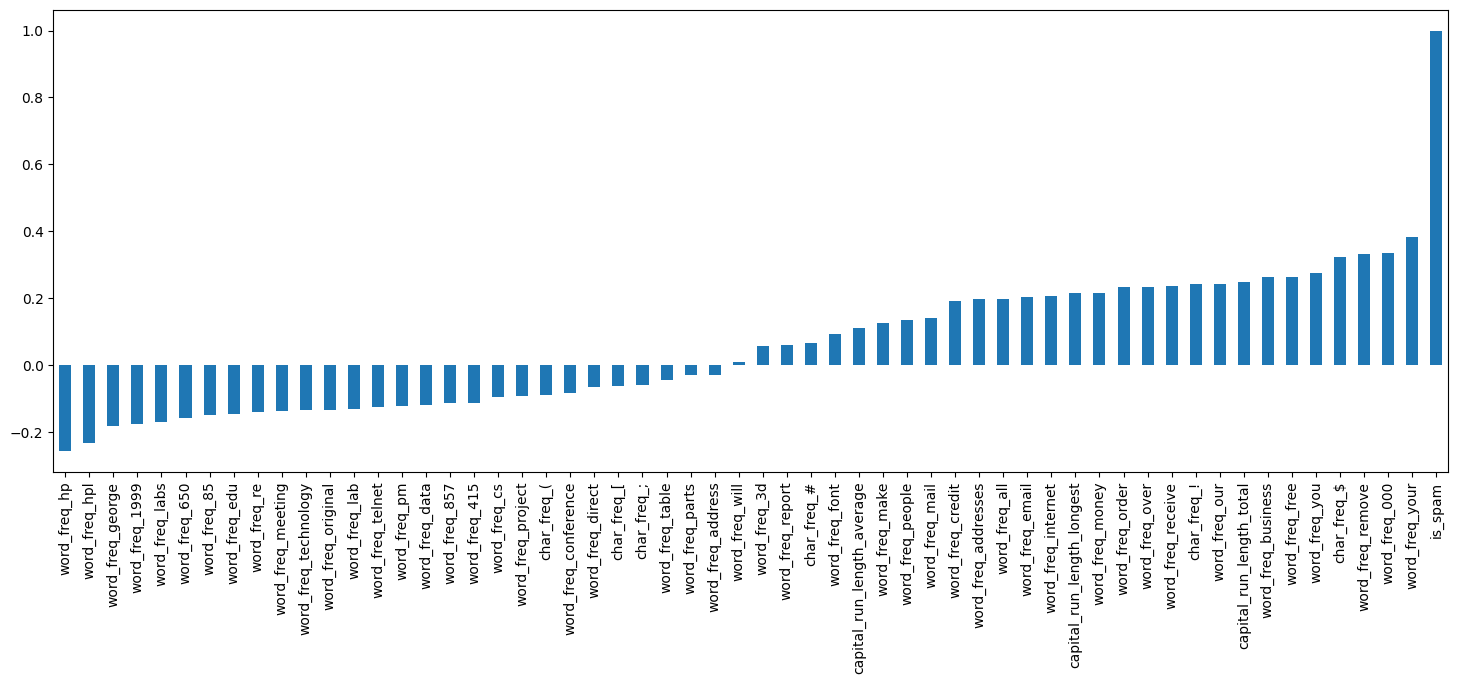

In [ ]:
df_pd = df.toPandas()
df_pd.corr()['is_spam'].sort_values().plot(kind='bar', figsize=(18, 6))

In [ ]:
input_columns = df.columns[:-1]

correlations = {}

for feature_name in input_columns:
    correlation = df.stat.corr(feature_name, "is_spam")
    print(f"Correlation between {feature_name} and is_spam: {correlation}")
    correlations[feature_name] = correlation

selected_features = [feature for feature, corr in correlations.items() if abs(corr) >= 0.1]

print("Selected features based on correlation >= 0.2 (absolute value):")
print(selected_features)

selected_columns = selected_features + ["is_spam"]
selected_data = df.select(*selected_columns)



Correlation between word_freq_make and is_spam: 0.1262075747276301
Correlation between word_freq_address and is_spam: -0.030223579212025984
Correlation between word_freq_all and is_spam: 0.19698797268316062
Correlation between word_freq_3d and is_spam: 0.05737138961859557
Correlation between word_freq_our and is_spam: 0.2419204377148721
Correlation between word_freq_over and is_spam: 0.23260430017220934
Correlation between word_freq_remove and is_spam: 0.3321174156141383
Correlation between word_freq_internet and is_spam: 0.2068084757616911
Correlation between word_freq_order and is_spam: 0.23155143128603223
Correlation between word_freq_mail and is_spam: 0.13896211329516528
Correlation between word_freq_receive and is_spam: 0.23452927138247492
Correlation between word_freq_will and is_spam: 0.007740737297957517
Correlation between word_freq_people and is_spam: 0.13292672586848697
Correlation between word_freq_report and is_spam: 0.060027316399875005
Correlation between word_freq_addre

# FEATURE SELECTION

In [ ]:
# Adding the target column 'is_spam' to the list of columns to select
# selected_columns = selected_features + ["is_spam"]


#These are from random forest important features...
selected_features = ['char_freq_!', 'word_freq_remove', 'char_freq_$', 'word_freq_hp', 'capital_run_length_average', 'word_freq_free', 'word_freq_your', 'capital_run_length_total', 'word_freq_money', 'word_freq_000', 'capital_run_length_longest', 'word_freq_you', 'word_freq_all', 'word_freq_george', 'word_freq_1999', 'word_freq_hpl', 'word_freq_our', 'word_freq_edu', 'word_freq_internet', 'word_freq_business', 'word_freq_over', 'word_freq_85', 'word_freq_650', 'word_freq_labs', 'word_freq_re']

selected_columns =  selected_features + ["is_spam"]

selected_data = df.select(*selected_columns)

print(len(selected_data.columns))

selected_data.show(5)

26
+-----------+----------------+-----------+------------+--------------------------+--------------+--------------+------------------------+---------------+-------------+--------------------------+-------------+-------------+----------------+--------------+-------------+-------------+-------------+------------------+------------------+--------------+------------+-------------+--------------+------------+-------+
|char_freq_!|word_freq_remove|char_freq_$|word_freq_hp|capital_run_length_average|word_freq_free|word_freq_your|capital_run_length_total|word_freq_money|word_freq_000|capital_run_length_longest|word_freq_you|word_freq_all|word_freq_george|word_freq_1999|word_freq_hpl|word_freq_our|word_freq_edu|word_freq_internet|word_freq_business|word_freq_over|word_freq_85|word_freq_650|word_freq_labs|word_freq_re|is_spam|
+-----------+----------------+-----------+------------+--------------------------+--------------+--------------+------------------------+---------------+-------------+----

# SCALING

In [ ]:
# # Assemble features
# assembler = VectorAssembler(inputCols=df.columns[:-1], outputCol="features")
# data = assembler.transform(df.withColumnRenamed("label", "is_spam"))  # Rename if your DataFrame hasn't this column named as "is_spam"

# # Split the data
# (train_data, test_data) = data.randomSplit([0.8, 0.2])


#========================


# # Assemble features
# assembler = VectorAssembler(inputCols=df.columns[:-1], outputCol="unscaled_features")
# assembled_data = assembler.transform(df.withColumnRenamed("label", "is_spam"))  # Rename if your DataFrame hasn't this column named as "is_spam"

# # Scale the assembled features
# scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=False)
# scalerModel = scaler.fit(assembled_data)
# scaled_data = scalerModel.transform(assembled_data)

# # Now you can split the scaled data
# (train_data, test_data) = scaled_data.randomSplit([0.8, 0.2])


# ===============================

# Assemble features
assembler = VectorAssembler(inputCols=selected_data.columns[:-1], outputCol="unscaled_features")
assembled_data = assembler.transform(selected_data.withColumnRenamed("label", "is_spam"))  # Rename if your DataFrame hasn't this column named as "is_spam"

# Scale the assembled features
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=False)
scalerModel = scaler.fit(assembled_data)
scaled_data = scalerModel.transform(assembled_data)

(train_data, test_data) = scaled_data.randomSplit([0.8, 0.2])



# EVALUATING MODEL - Function

In [ ]:
# Define a UDF to convert the probability column to rawPrediction format
to_raw_prediction_udf = udf(lambda prob: Vectors.dense([1.0 - prob[1], prob[1]]), VectorUDT())



# def evaluate_model(predictions):
#     # Ensure the DataFrame includes a 'probability' column and transform it to 'rawPrediction'
#     if 'probability' in predictions.columns:
#         predictions = predictions.withColumn("rawPrediction", to_raw_prediction_udf(col("probability")))

#     # Convert to RDD format for evaluation using MulticlassMetrics
#     predictionAndLabels = predictions.select("prediction", "is_spam").rdd.map(lambda p: (float(p[0]), float(p[1])))
#     metrics = MulticlassMetrics(predictionAndLabels)

#     # Compute standard classification metrics
#     confusionMatrix = metrics.confusionMatrix().toArray()
#     precision = metrics.precision(1.0)
#     recall = metrics.recall(1.0)
#     f1Score = metrics.fMeasure(1.0)
#     accuracy = metrics.accuracy

#     print(f"Accuracy: {accuracy}")
#     print("Confusion Matrix:")
#     print(confusionMatrix)
#     print(f"Precision: {precision}")
#     print(f"Recall: {recall}")
#     print(f"F1 Score: {f1Score}")


#     # Compute AUC ROC using BinaryClassificationEvaluator
#     # This requires the 'rawPrediction' column in the expected format
#     if 'rawPrediction' in predictions.columns:
#         binary_evaluator = BinaryClassificationEvaluator(labelCol="is_spam", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
#         auc_roc = binary_evaluator.evaluate(predictions)
#         print(f"AUC ROC: {auc_roc}")
#     else:
#         print("AUC ROC: Unable to compute without 'rawPrediction' or 'probability' column.")


def evaluate_model(predictions, cost_fp=10, cost_fn=1):
    """
    Evaluate the model with additional Total Misclassification Cost.

    Parameters:
    - predictions: DataFrame containing 'prediction', 'is_spam', and 'probability' columns
    - cost_fp: The cost of a false positive
    - cost_fn: The cost of a false negative
    """
    # Ensure the DataFrame includes a 'probability' column and transform it to 'rawPrediction'
    if 'probability' in predictions.columns:
        to_raw_prediction_udf = udf(lambda prob: Vectors.dense([1.0 - prob[1], prob[1]]), VectorUDT())
        predictions = predictions.withColumn("rawPrediction", to_raw_prediction_udf(col("probability")))

    # Convert to RDD format for evaluation using MulticlassMetrics
    predictionAndLabels = predictions.select("prediction", "is_spam").rdd.map(lambda p: (float(p[0]), float(p[1])))
    metrics = MulticlassMetrics(predictionAndLabels)

    # Compute standard classification metrics
    confusionMatrix = metrics.confusionMatrix().toArray()
    TP = confusionMatrix[1, 1]
    TN = confusionMatrix[0, 0]
    FP = confusionMatrix[0, 1]
    FN = confusionMatrix[1, 0]

    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    accuracy = metrics.accuracy

    # Calculate Total Misclassification Cost
    total_cost = (cost_fp * FP) + (cost_fn * FN)

    # Print metrics
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(confusionMatrix)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1Score}")
    print(f"Total Misclassification Cost: {total_cost}")

    # Compute AUC ROC using BinaryClassificationEvaluator, if possible
    if 'rawPrediction' in predictions.columns:
        binary_evaluator = BinaryClassificationEvaluator(labelCol="is_spam", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
        auc_roc = binary_evaluator.evaluate(predictions)
        print(f"AUC ROC: {auc_roc}")
    else:
        print("AUC ROC: Unable to compute without 'rawPrediction' or 'probability' column.")


# DT Model

In [ ]:
dt_classifier = DecisionTreeClassifier(labelCol="is_spam", featuresCol="features")
dt_model = dt_classifier.fit(train_data)
dt_predictions = dt_model.transform(test_data)

print("Decision Tree Classifier:")

evaluate_model(dt_predictions)

Decision Tree Classifier:


/content/spark-3.2.3-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.9061135371179039
Confusion Matrix:
[[521.  28.]
 [ 58. 309.]]
Precision: 0.9169139465875371
Recall: 0.8419618528610354
F1 Score: 0.8778409090909092
Total Misclassification Cost: 338.0
AUC ROC: 0.923154807105314


# NAIVE BAYES Model

In [ ]:

nb_classifier = NaiveBayes(labelCol="is_spam", featuresCol="features")
nb_model = nb_classifier.fit(train_data)
nb_predictions = nb_model.transform(test_data)

print("Naive Bayes Classifier:")
evaluate_model(nb_predictions)


Naive Bayes Classifier:
Accuracy: 0.8679039301310044
Confusion Matrix:
[[439. 110.]
 [ 11. 356.]]
Precision: 0.7639484978540773
Recall: 0.9700272479564033
F1 Score: 0.8547418967587035
Total Misclassification Cost: 1111.0
AUC ROC: 0.9661162480209226


# SVM Model

In [ ]:
svm_classifier = LinearSVC(labelCol="is_spam", featuresCol="features")

svm_model = svm_classifier.fit(train_data)

svm_predictions = svm_model.transform(test_data)

print("SVM Classifier")

evaluate_model(svm_predictions)

SVM Classifier
Accuracy: 0.9213973799126638
Confusion Matrix:
[[516.  33.]
 [ 39. 328.]]
Precision: 0.9085872576177285
Recall: 0.8937329700272479
F1 Score: 0.901098901098901
Total Misclassification Cost: 369.0
AUC ROC: 0.968131306363315


# LR Model

In [ ]:
lr_classifier = LogisticRegression(labelCol="is_spam", featuresCol="features")
lr_model = lr_classifier.fit(train_data)
lr_predictions = lr_model.transform(test_data)

print("Logistic Regression Classifier")

evaluate_model(lr_predictions)

Logistic Regression Classifier
Accuracy: 0.9148471615720524
Confusion Matrix:
[[511.  38.]
 [ 40. 327.]]
Precision: 0.8958904109589041
Recall: 0.8910081743869209
F1 Score: 0.8934426229508197
Total Misclassification Cost: 420.0
AUC ROC: 0.9685333253922145


# FR Model

In [ ]:
rf_classifier = RandomForestClassifier(labelCol="is_spam", featuresCol="features")
rf_model = rf_classifier.fit(train_data)
rf_predictions = rf_model.transform(test_data)

print("Random Forest Classifier")

evaluate_model(rf_predictions)

Random Forest Classifier
Accuracy: 0.9344978165938864
Confusion Matrix:
[[531.  18.]
 [ 42. 325.]]
Precision: 0.9475218658892128
Recall: 0.885558583106267
F1 Score: 0.9154929577464789
Total Misclassification Cost: 222.0
AUC ROC: 0.9749482586620195


# Feature Importance

In [ ]:
# Extracting feature importances
importances = rf_model.featureImportances

# Converting feature importances to a list
importances_list = importances.toArray()

# Pair each feature name with its importance and sort them by importance in descending order
feature_importance_pairs = sorted(zip(selected_features, importances_list), key=lambda x: x[1], reverse=True)

top_20_features = feature_importance_pairs[:25]

top_20_feature_names = [feature[0] for feature in top_20_features] + ["is_spam"]

print("Top 25 important features:")
print(top_20_feature_names)

top_features_data = df.select(*top_20_feature_names)

top_features_data.show(5)


Top 25 important features:
['word_freq_remove', 'char_freq_!', 'char_freq_$', 'word_freq_free', 'word_freq_your', 'capital_run_length_average', 'capital_run_length_longest', 'word_freq_hp', 'word_freq_000', 'word_freq_money', 'capital_run_length_total', 'word_freq_hpl', 'word_freq_george', 'word_freq_all', 'word_freq_our', 'word_freq_you', 'word_freq_edu', 'word_freq_internet', 'word_freq_1999', 'word_freq_650', 'word_freq_labs', 'word_freq_85', 'word_freq_business', 'word_freq_over', 'word_freq_re', 'is_spam']
+----------------+-----------+-----------+--------------+--------------+--------------------------+--------------------------+------------+-------------+---------------+------------------------+-------------+----------------+-------------+-------------+-------------+-------------+------------------+--------------+-------------+--------------+------------+------------------+--------------+------------+-------+
|word_freq_remove|char_freq_!|char_freq_$|word_freq_free|word_freq_you

# PARAMETER TUNING

In [ ]:
lr = LogisticRegression(labelCol="is_spam", featuresCol="features")

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="is_spam", metricName="areaUnderROC")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_data)

bestModel = cvModel.bestModel

test_predictions = bestModel.transform(test_data)

evaluate_model(test_predictions)

print("Best model parameters for Logistic Regression Classifier:")
print(f"RegParam: {bestModel._java_obj.getRegParam()}")
print(f"ElasticNetParam: {bestModel._java_obj.getElasticNetParam()}")
print(f"MaxIter: {bestModel._java_obj.getMaxIter()}")

Accuracy: 0.8992497320471597
Confusion Matrix:
[[537.  26.]
 [ 68. 302.]]
Precision: 0.9207317073170732
Recall: 0.8162162162162162
F1 Score: 0.8653295128939827
Total Misclassification Cost: 328.0
AUC ROC: 0.9642359944313791
Best model parameters for Logistic Regression Classifier:
RegParam: 0.01
ElasticNetParam: 0.0
MaxIter: 50


In [ ]:
svm = LinearSVC(labelCol="is_spam", featuresCol="features")


evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="is_spam", metricName="areaUnderROC")

paramGrid = ParamGridBuilder() \
    .addGrid(svm.regParam, [0.01, 0.1, 0.5]) \
    .addGrid(svm.maxIter, [10, 100, 200]) \
    .build()

crossval = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_data)

bestModel = cvModel.bestModel

test_predictions = bestModel.transform(test_data)

evaluate_model(test_predictions)

print("Best model parameters for SVM Classifier:")
print(f"RegParam: {bestModel._java_obj.getRegParam()}")
print(f"MaxIter: {bestModel._java_obj.getMaxIter()}")

Accuracy: 0.9110396570203644
Confusion Matrix:
[[535.  28.]
 [ 55. 315.]]
Precision: 0.9183673469387755
Recall: 0.8513513513513513
F1 Score: 0.8835904628330996
Total Misclassification Cost: 335.0
AUC ROC: 0.9695789928472013
Best model parameters for SVM Classifier:
RegParam: 0.01
MaxIter: 100


In [ ]:
rf = RandomForestClassifier(labelCol="is_spam", featuresCol="features")

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="is_spam", metricName="areaUnderROC")

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 50]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .addGrid(rf.impurity, ["gini", "entropy"]) \
    .build()

crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

cvModel = crossval.fit(train_data)

bestModel = cvModel.bestModel

test_predictions = bestModel.transform(test_data)

evaluate_model(test_predictions)

print(f"Best model parameters for Random Forest Classifier:")
print(f"Number of Trees: {bestModel.getNumTrees}")
print(f"Max Depth: {bestModel.getOrDefault('maxDepth')}")
print(f"Impurity: {bestModel.getOrDefault('impurity')}")

Accuracy: 0.9519650655021834
Confusion Matrix:
[[526.  23.]
 [ 21. 346.]]
Precision: 0.9376693766937669
Recall: 0.9427792915531336
F1 Score: 0.940217391304348
Total Misclassification Cost: 251.0
AUC ROC: 0.9867557064367706
Best model parameters for Random Forest Classifier:
Number of Trees: 50
Max Depth: 20
Impurity: entropy
